Challenge - Time Series Analysis
Using a different time series data set (either from FRED or elsewhere, go about the process of time series modeling. 

Specifically generate the following things:

Plot the time series, along with any logical or necessary differences to get a stationary dataset

Generate and interpret a PACF for the time series (and/or its differences)

Generate 5 ARIMA specifications and evaluate their efficacy at modeling your data

Finally choose one specification and make the case for that as a logical model for your dataset.

This should come in the form of a notebook with the necessary prose to explain your process. 

Remember to use the tools of text, visuals, and analysis to tell a clear and concise story with your data.

**Curriculum didn't give examples of multivariate time-series.**

https://www.youtube.com/watch?v=D9y6dcy0xK8

## Predicting Bitcoin Prices 

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
# column titles
c_titles = ["time", "low", "high", "open", "close", "volume"] 
# read_csv. create date as index
bitcoin = pd.read_csv("crypto_data/BTC-USD.csv", index_col=0, names=c_titles)
# convert index from unix-time stamp to pandas datetime, unit is seconds
bitcoin.index = pd.to_datetime(bitcoin.index, unit='s')
bitcoin = bitcoin[['close']]

In [3]:
bitcoin.head()

,close
time,
2018-06-14 09:31:00,6489.549805
2018-06-14 09:32:00,6487.379883
2018-06-14 09:33:00,6479.410156
2018-06-14 09:34:00,6479.410156
2018-06-14 09:35:00,6479.979980


In [4]:
# included months
np.unique(bitcoin.index.month)

array([6, 7, 8], dtype=int64)

In [5]:
# included hours
np.unique(bitcoin.index.hour)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23], dtype=int64)

### Daily Trends

In [6]:
daily_data = []
import calendar

for month_idx in [6, 7, 8]:
    # + 1 +-1 to prevent days that don't have data for full 24 hour
    minimum_day = int(bitcoin.loc[f"2018-{month_idx}"].index.min().strftime('%d')) + 1
    maximum_day = int(bitcoin.loc[f"2018-{month_idx}"].index.max().strftime('%d')) - 1
    random_days = np.random.choice(np.arange(minimum_day,maximum_day), 3)
    for day in random_days:
        # get data for randomly selected day in a given month
        daily_d = bitcoin.close.loc[f'2018-{month_idx}-{day}-00:00:00':f'2018-{month_idx}-{day} 23:59:00']
        # index shall be hour only
        daily_d.index = daily_d.index.strftime("%H")
        # rename series 
        daily_d = daily_d.rename(f"{calendar.month_abbr[month_idx]} {day}")
        # group by and find mean per hour
        daily_data.append(daily_d.groupby(by=daily_d.index).mean())

In [7]:
combined_daily = pd.concat(daily_data, axis=1, sort=True)
combined_daily.loc[:, 'hour'] = combined_daily.index
combined_daily.head()

,Jun 28,Jun 24,Jun 21,Jul 3,Jul 18,Jul 23,Aug 14,Aug 3,Aug 5,hour
00,6143.197453,6144.128784,6755.638542,6610.699813,7340.202205,7431.477360,6227.069840,7443.988973,6992.568482,00
01,6132.688135,6114.222485,6753.388574,6611.484635,7338.229110,7470.598657,6178.349333,7352.601278,6928.064673,01
02,6128.888582,6113.697518,6770.719816,6622.666365,7363.165495,7598.966357,5970.556299,7335.632381,6932.769653,02
03,6107.702710,6102.520158,6769.680623,6632.216683,7480.517668,7622.957780,5967.389307,7345.796965,6972.736540,03
04,6090.919694,5985.472689,6761.857447,6644.561288,7437.074675,7654.570492,6011.305802,7308.642969,6987.092684,04


In [8]:
melted_daily = pd.melt(combined_daily, id_vars="hour")
melted_daily.head()

,hour,variable,value
0,00,Jun 28,6143.197453
1,01,Jun 28,6132.688135
2,02,Jun 28,6128.888582
3,03,Jun 28,6107.702710
4,04,Jun 28,6090.919694


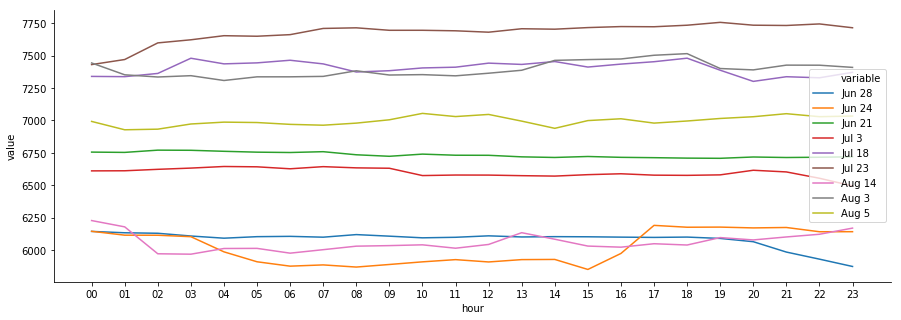

In [9]:
plt.figure(figsize=(15,5))
sns.lineplot(x="hour", y="value", hue="variable", data = melted_daily)
sns.despine()

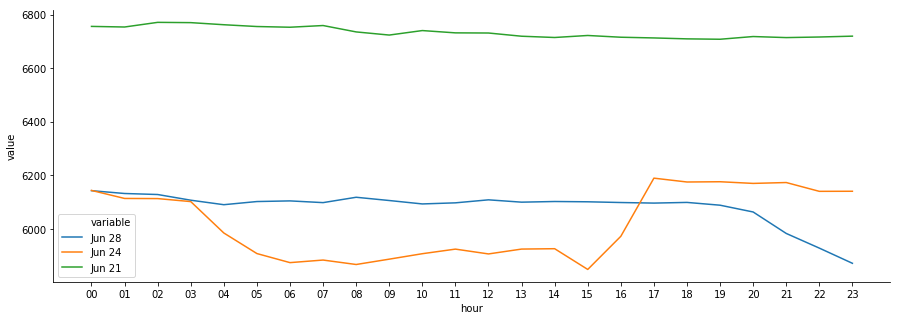

In [10]:
june = melted_daily[melted_daily.variable.str.contains("Jun")]
plt.figure(figsize=(15,5))
sns.lineplot(x="hour", y="value", hue="variable", data = june)
sns.despine()

In [11]:
# number of days in may
len(bitcoin[(bitcoin.index.month == 6)].index.day.unique())

17

In [12]:
# number of days in june
len(bitcoin[(bitcoin.index.month == 7)].index.day.unique())

31

In [13]:
# number of days in july
len(bitcoin["2018-08"].index.day.unique())

22

### Stationary 

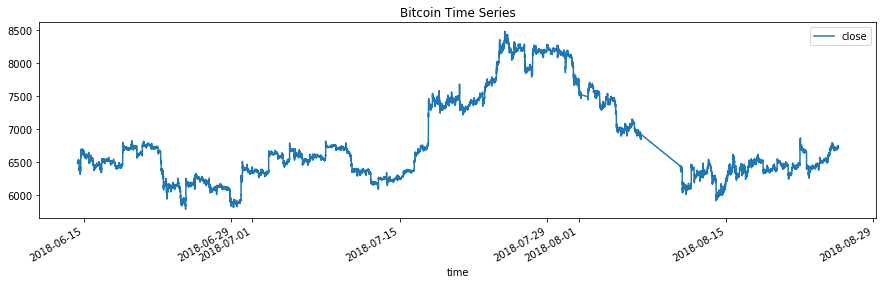

In [14]:
# overall trend
bitcoin.plot(figsize=(15,4))
plt.title('Bitcoin Time Series')
plt.show()

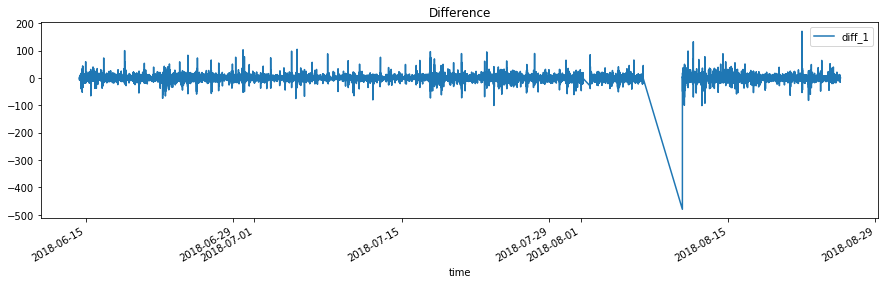

In [15]:
bitcoin['diff_1'] = bitcoin.close - bitcoin.close.shift()
bitcoin = bitcoin.fillna(method="ffill").dropna()
bitcoin.plot(y='diff_1', figsize=(15,4))
plt.title('Difference')
plt.show()

In [16]:
# large difference where?
bitcoin[bitcoin.diff_1 < -400].index

DatetimeIndex(['2018-08-10 16:20:00'], dtype='datetime64[ns]', name='time', freq=None)

In [17]:
bitcoin.loc['2018-08-10 16:20:00']

close     6433.430176
diff_1    -480.339844
Name: 2018-08-10 16:20:00, dtype: float64

In [18]:
# see the data for August 10
bitcoin.loc["2018-08-10"].head()

,close,diff_1
time,,
2018-08-10 16:20:00,6433.430176,-480.339844
2018-08-10 16:21:00,6425.060059,-8.370117
2018-08-10 16:22:00,6422.390137,-2.669922
2018-08-10 16:23:00,6423.459961,1.069824
2018-08-10 16:24:00,6425.060059,1.600098


In [19]:
# what is before:  august 09, 08, 07 are missing. August 6 is the previous value
bitcoin.loc["2018-08-06"].tail(1)

,close,diff_1
time,,
2018-08-06 23:06:00,6913.77002,-2.45996


In [20]:
# The data is sequential but it contains discountinuity
for month_idx in [6,7,8]:
    mini = bitcoin.loc[f"2018-{month_idx}"].index.min()
    maxi = bitcoin.loc[f"2018-{month_idx}"].index.max()
    print(f"{calendar.month_abbr[month_idx]}: minimum: {mini}, maximum: {maxi}")

Jun: minimum: 2018-06-14 09:32:00, maximum: 2018-06-30 23:59:00
Jul: minimum: 2018-07-01 00:00:00, maximum: 2018-07-31 23:59:00
Aug: minimum: 2018-08-01 00:00:00, maximum: 2018-08-25 16:40:00


### Modeling: ARIMA

Text(0.5, 1.0, 'Bitcoin')

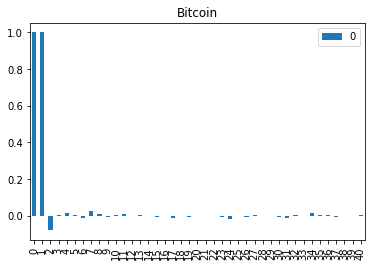

In [21]:
from statsmodels.tsa.stattools import pacf
x_acf = pd.DataFrame(pacf(bitcoin.close))
x_acf.plot(kind='bar')
plt.title("Bitcoin")

Text(0.5, 1.0, 'Bitcoin')

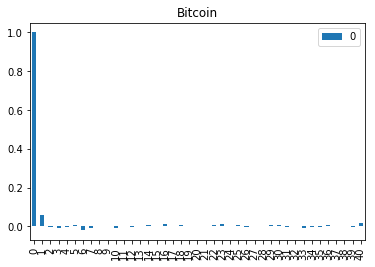

In [22]:
from statsmodels.tsa.stattools import pacf
x_acf = pd.DataFrame(pacf(bitcoin.diff_1))
x_acf.plot(kind='bar')
plt.title("Bitcoin")

In [23]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(bitcoin.close, order=(0,1,0))
model_fit = model.fit()
print(model_fit.summary())
print('Residuals Description')
print(model_fit.resid.describe())

C:\Users\Tinsae\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Tinsae\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Tinsae\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
C:\Users\Tinsae\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1344: Futu

                             ARIMA Model Results                              
Dep. Variable:                D.close   No. Observations:                97722
Model:                 ARIMA(0, 1, 0)   Log Likelihood             -308507.532
Method:                           css   S.D. of innovations              5.686
Date:                Tue, 12 Mar 2019   AIC                         617019.064
Time:                        06:09:04   BIC                         617038.044
Sample:                             1   HQIC                        617024.830
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.018      0.128      0.898      -0.033       0.038
Residuals Description
count    9.772200e+04
mean     7.653009e-08
std      5.686291e+00
min     -4.803422e+02
25%     -2.225442e-01

In [24]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(bitcoin.close, order=(1,0,0))
model_fit = model.fit()
print(model_fit.summary())
print('Residuals Description')
print(model_fit.resid.describe())

C:\Users\Tinsae\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                              ARMA Model Results                              
Dep. Variable:                  close   No. Observations:                97723
Model:                     ARMA(1, 0)   Log Likelihood             -308513.972
Method:                       css-mle   S.D. of innovations              5.686
Date:                Tue, 12 Mar 2019   AIC                         617033.944
Time:                        06:09:05   BIC                         617062.414
Sample:                             0   HQIC                        617042.593
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        6773.5261    324.691     20.861      0.000    6137.142    7409.910
ar.L1.close     1.0000   2.62e-05   3.82e+04      0.000       1.000       1.000
                                    Roots       

In [25]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(bitcoin.close, order=(1,0,1))
model_fit = model.fit()
print(model_fit.summary())
print('Residuals Description')
print(model_fit.resid.describe())

C:\Users\Tinsae\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                              ARMA Model Results                              
Dep. Variable:                  close   No. Observations:                97723
Model:                     ARMA(1, 1)   Log Likelihood             -308337.975
Method:                       css-mle   S.D. of innovations              5.676
Date:                Tue, 12 Mar 2019   AIC                         616683.951
Time:                        06:11:47   BIC                         616721.910
Sample:                             0   HQIC                        616695.482
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        6773.5230    316.801     21.381      0.000    6152.605    7394.441
ar.L1.close     0.9999   2.78e-05   3.59e+04      0.000       1.000       1.000
ma.L1.close     0.0599      0.003     18.822    

In [26]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(bitcoin.close, order=(1,1,1))
model_fit = model.fit()
print(model_fit.summary())
print('Residuals Description')
print(model_fit.resid.describe())

C:\Users\Tinsae\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Tinsae\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.close   No. Observations:                97722
Model:                 ARIMA(1, 1, 1)   Log Likelihood             -308331.467
Method:                       css-mle   S.D. of innovations              5.676
Date:                Tue, 12 Mar 2019   AIC                         616670.933
Time:                        06:13:51   BIC                         616708.893
Sample:                             1   HQIC                        616682.465
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0023      0.019      0.120      0.904      -0.035       0.040
ar.L1.D.close     0.0277      0.046      0.601      0.548      -0.063       0.118
ma.L1.D.close     0.0323      0.046     

Text(0.5, 1.0, 'Histogram of Residuals')

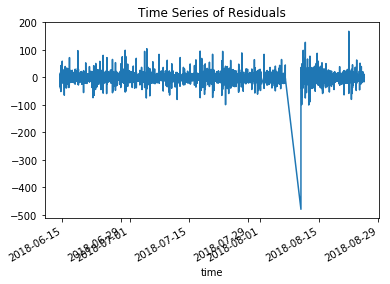

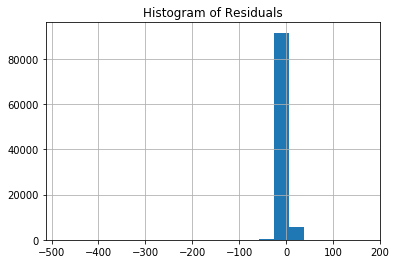

In [27]:
residuals = pd.DataFrame(model_fit.resid)

residuals.plot(legend=False)
plt.title('Time Series of Residuals')

residuals.hist(bins=20)
plt.title('Histogram of Residuals')

### Predicing Closing Price in June

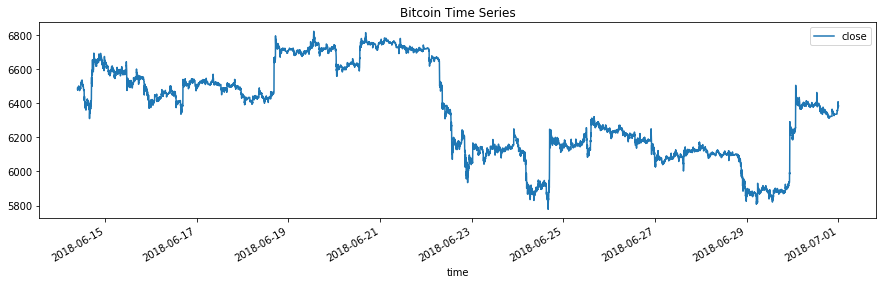

In [29]:
bitcoin_june = bitcoin.loc["2018-06"].drop("diff_1", axis=1).copy()
# june trend,seasonality
bitcoin_june.plot(figsize=(15,4))
plt.title('Bitcoin Time Series')
plt.show()

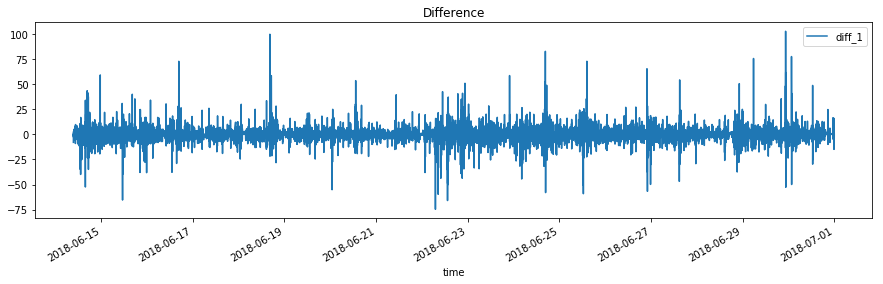

In [30]:
bitcoin_june['diff_1'] = bitcoin_june.close - bitcoin_june.close.shift()
bitcoin_june = bitcoin_june.fillna(method="ffill").dropna()
bitcoin_june.plot(y='diff_1', figsize=(15,4))
plt.title('Difference')
plt.show()

Text(0.5, 1.0, 'Bitcoin')

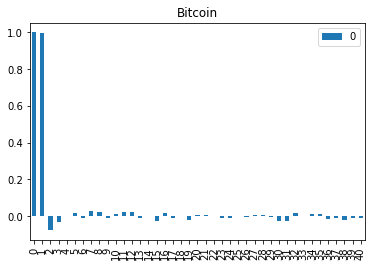

In [40]:
from statsmodels.tsa.stattools import pacf
x_acf = pd.DataFrame(pacf(bitcoin_june.close))
x_acf.plot(kind='bar')
plt.title("Bitcoin")

In [31]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(bitcoin_june.close, order=(0,1,0))
model_fit = model.fit()
print(model_fit.summary())
print('Residuals Description')
print(model_fit.resid.describe())

                             ARIMA Model Results                              
Dep. Variable:                D.close   No. Observations:                23806
Model:                 ARIMA(0, 1, 0)   Log Likelihood              -73338.073
Method:                           css   S.D. of innovations              5.268
Date:                Tue, 12 Mar 2019   AIC                         146680.146
Time:                        06:17:37   BIC                         146696.301
Sample:                             1   HQIC                        146685.387
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0040      0.034     -0.118      0.906      -0.071       0.063
Residuals Description
count    2.380600e+04
mean    -4.242344e-08
std      5.268457e+00
min     -7.472594e+01
25%     -1.761332e-01

C:\Users\Tinsae\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Tinsae\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Tinsae\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
C:\Users\Tinsae\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1344: Futu

In [35]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(bitcoin_june.close, order=(5,2,5))
model_fit = model.fit()
print(model_fit.summary())
print('Residuals Description')
print(model_fit.resid.describe())

C:\Users\Tinsae\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Tinsae\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Tinsae\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


                             ARIMA Model Results                              
Dep. Variable:               D2.close   No. Observations:                23805
Model:                 ARIMA(5, 2, 5)   Log Likelihood              -73279.897
Method:                       css-mle   S.D. of innovations              5.255
Date:                Tue, 12 Mar 2019   AIC                         146583.793
Time:                        06:20:03   BIC                         146680.725
Sample:                             2   HQIC                        146615.241
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const           1.688e-06   5.37e-06      0.314      0.753   -8.83e-06    1.22e-05
ar.L1.D2.close    -2.0548        nan        nan        nan         nan         nan
ar.L2.D2.close    -2.3134        nan

C:\Users\Tinsae\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:1455: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))
C:\Users\Tinsae\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\Tinsae\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\Tinsae\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [36]:
len(bitcoin_june)

23807

### Train Test Split

In [37]:
bitcoin_june = bitcoin_june[['close']]

In [38]:
split_point = int(len(bitcoin_june)*0.80)
split_point

19045

In [39]:
train = bitcoin_june.iloc[0:split_point]
test = bitcoin_june.iloc[split_point:]

In [58]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(train, order=(5,1,5))
# what is desp 0
model_fit = model.fit(desp=0)
print(model_fit.summary())
print('Residuals Description')
print(model_fit.resid.describe())

C:\Users\Tinsae\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Tinsae\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.close   No. Observations:                19044
Model:                 ARIMA(5, 1, 5)   Log Likelihood              -58650.490
Method:                       css-mle   S.D. of innovations              5.264
Date:                Tue, 12 Mar 2019   AIC                         117324.980
Time:                        06:31:40   BIC                         117419.234
Sample:                             1   HQIC                        117355.890
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0198      0.038     -0.517      0.605      -0.095       0.055
ar.L1.D.close     0.5214      0.160      3.258      0.001       0.208       0.835
ar.L2.D.close     0.3837      0.174     

Text(0.5, 1.0, 'Histogram of Residuals')

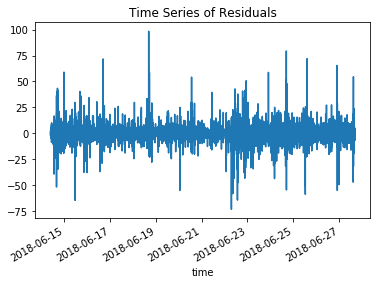

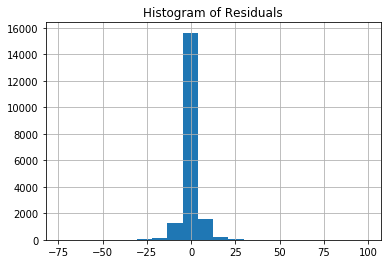

In [59]:
residuals = pd.DataFrame(model_fit.resid)

residuals.plot(legend=False)
plt.title('Time Series of Residuals')

residuals.hist(bins=20)
plt.title('Histogram of Residuals')

In [60]:
predictions = []
for t in range(len(test)):
    # why zero?
    predictions.append(model_fit.forecast()[0])
predictions[120:125]

[array([6101.52122273]),
 array([6101.52122273]),
 array([6101.52122273]),
 array([6101.52122273]),
 array([6101.52122273])]

In [61]:
from sklearn.metrics import mean_squared_error
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

Test MSE: 36799.153
